## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Uncomment the next line and install the package, in case you don't have it in your environment
#%pip install procyclingstats

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Added package
import procyclingstats as pcs

import re

import os
import sys
sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *

In [4]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists.csv'))
races_df = pd.read_csv(os.path.join('dataset','races.csv'))

## Exploration

We begin with a preliminary exploration of the two datasets.

### Cyclists

In [5]:
cyclist_df.shape

(6134, 6)

In [6]:
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [7]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


We can see that there are missing values. Specifically, a lot of cyclists don't have their height and/or weight indicated. 
But first, let's check duplicates.

#### Consistency

Some datatypes can be converted

In [8]:
# We can't convert this because in the end we can't plot it as kde. Sad but true
# cyclist_df["birth_year"] = pd.to_numeric(cyclist_df["birth_year"], errors='coerce').astype('Int64') 

cyclist_df.dtypes

_url            object
name            object
birth_year     float64
weight         float64
height         float64
nationality     object
dtype: object

Let's also process the strings

In [9]:
cyclist_df["name"] = cyclist_df["name"].apply(lambda nome: ' '.join(nome.split()))

#### Duplicates

First, a general check.

In [10]:
duplicates = cyclist_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


To really find duplicates the values that it makes sense to check are the cyclists' names and identifiers

In [11]:
cyclist_df[cyclist_df["_url"].duplicated(keep="first")]

,_url,name,birth_year,weight,height,nationality


No duplicate URLs (i.e. identifiers). There are homonyms though, so one shoud be aware of this.

In [12]:
cyclist_df[cyclist_df["name"].duplicated(keep=False)]

,_url,name,birth_year,weight,height,nationality
347,andrea-peron-1,Andrea Peron,1971.0,70.0,183.0,Italy
1745,roman-kreuziger-sr,Roman Kreuziger,1965.0,NaN,NaN,Czech Republic
2235,alessandro-pozzi2,Alessandro Pozzi,1969.0,NaN,NaN,Italy
2601,roman-kreuziger,Roman Kreuziger,1986.0,65.0,183.0,Czech Republic
2682,andrea-peron,Andrea Peron,1988.0,70.0,178.0,Italy
2862,antonio-cabello-baena,Antonio Cabello,1990.0,67.0,179.0,Spain
2939,jesus-lopez23,Jesús López,1955.0,NaN,NaN,Spain
2953,alberto-fernandez-sainz,Alberto Fernández,1981.0,NaN,NaN,Spain
3238,antonio-cabello,Antonio Cabello,1956.0,NaN,NaN,Spain
4917,sergio-dominguez-rodriguez,Sergio Domínguez,1979.0,NaN,NaN,Spain


Upon manual checking, all these cyclists exist, therefore there are no duplicated rows. Let's get back to checking the missing values

#### Missing Data

In [13]:
n_rows = cyclist_df.shape[0]
for col in cyclist_df.columns:
    print(f"There are {n_rows - cyclist_df[col].count()} null values in the {col} column, i.e. {100*(n_rows - cyclist_df[col].count())/n_rows:.2f}% are missing")

There are 0 null values in the _url column, i.e. 0.00% are missing
There are 0 null values in the name column, i.e. 0.00% are missing
There are 13 null values in the birth_year column, i.e. 0.21% are missing
There are 3056 null values in the weight column, i.e. 49.82% are missing
There are 2991 null values in the height column, i.e. 48.76% are missing
There are 1 null values in the nationality column, i.e. 0.02% are missing


Do cyclists that don't have a weight assigned at least have an height, or vice versa?

In [14]:
# Count the number of rows missing both weight and height
missing_weight_height_count = cyclist_df[cyclist_df['weight'].isna() & cyclist_df['height'].isna()].shape[0]
print(f"Number of rows missing both weight and height: {missing_weight_height_count}")
missing_weight_or_height_count = cyclist_df[cyclist_df['weight'].isna() | cyclist_df['height'].isna()].shape[0]
print(f"Number of rows missing either weight or height: {missing_weight_or_height_count}")

Number of rows missing both weight and height: 2984
Number of rows missing either weight or height: 3063


Almost none. This means using a regressor would be critical
Of all these cyclists, how many don't have a weight nor an height nor a birth year?

In [15]:
# .all(axis=1) is basically doing an AND along the columns. So we `.sum()` a Pandas series of length `cyclist_df.shape[0]`
with_no_info = cyclist_df[['birth_year', 'weight', 'height']].isna().all(axis=1)
print(f"There are {with_no_info.sum()} cyclists without birth_year, weight, height")
print("And they are:")
for _, row in cyclist_df[with_no_info].iterrows():
    print(f"_url: {row['_url']:<20} name: {row['name']:<20} nationality: {row['nationality']}")

There are 13 cyclists without birth_year, weight, height
And they are:
_url: scott-davies         name: Scott Davies         nationality: nan
_url: vladimir-malakov     name: Vladimir Malakov     nationality: Russia
_url: antonio-zanini       name: Antonio Zanini       nationality: Italy
_url: filippo-simonetti    name: Filippo Simonetti    nationality: Italy
_url: carlos-garcia        name: Carlos García        nationality: Spain
_url: alexandr-osipov      name: Alexandr Osipov      nationality: Russia
_url: nicolai-kosyakov     name: Nicolai Kosyakov     nationality: Russia
_url: nevens-guy           name: Guy Nevens           nationality: Belgium
_url: oscar-pumar          name: Oscar Pumar          nationality: Venezuela
_url: javier-luquin        name: Javier Luquin        nationality: Spain
_url: thierry-lauder       name: Thierry Lauder       nationality: France
_url: sergei-jermachenko   name: Sergei Jermachenko   nationality: Russia
_url: batik-odriozola      name: Batik Odrio

So, the above cyclist (very few) are missing the most crucial attributes. One of them is even missing the nationality.

### Races

In [16]:
races_df.shape

(589865, 18)

In [17]:
races_df.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


Looks like we don't have to reformat names.

In [18]:
n_rows = races_df.shape[0]
for col in races_df.columns:
    print(f"There are {n_rows - races_df[col].count():>6} null values in the {col:20} column, i.e. {100*(n_rows - races_df[col].count())/n_rows:>5.2f}% are missing")

There are      0 null values in the _url                 column, i.e.  0.00% are missing
There are      0 null values in the name                 column, i.e.  0.00% are missing
There are    477 null values in the points               column, i.e.  0.08% are missing
There are 338779 null values in the uci_points           column, i.e. 57.43% are missing
There are      0 null values in the length               column, i.e.  0.00% are missing
There are 147045 null values in the climb_total          column, i.e. 24.93% are missing
There are 148194 null values in the profile              column, i.e. 25.12% are missing
There are      0 null values in the startlist_quality    column, i.e.  0.00% are missing
There are 559932 null values in the average_temperature  column, i.e. 94.93% are missing
There are      0 null values in the date                 column, i.e.  0.00% are missing
There are      0 null values in the position             column, i.e.  0.00% are missing
There are      0 null

So,
- There are *no* missing values in the columns `_url`, `name`, `length`, `startlist_quality`, `date`, `position`, `cyclist`, `is_X`, `delta`
- There are *little* missing values in the columns `points`, `cyclist_age`
- There are *some* missing values in the columns `climb_total`, `profile`, `cyclist_team`
- There are *many* missing values in the column `uci_points`
- There are *a lot* of missing values in the column `average_temperature`

In [19]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

In [20]:
print(f"There are {len(races_df.select_dtypes(include='number').columns)} columns with numeric attributes.")
print(f"\t They are: {[col for col in races_df.select_dtypes(include='number').columns]}\n")
print(f"There are {len(races_df.select_dtypes(exclude='number').columns)} non-numeric attributes.")
print(f"\t They are: {[col for col in races_df.select_dtypes(exclude='number')]}")

There are 10 columns with numeric attributes.
	 They are: ['points', 'uci_points', 'length', 'climb_total', 'profile', 'startlist_quality', 'average_temperature', 'position', 'cyclist_age', 'delta']

There are 8 non-numeric attributes.
	 They are: ['_url', 'name', 'date', 'cyclist', 'is_tarmac', 'is_cobbled', 'is_gravel', 'cyclist_team']


Uci points are assigned to less than half of the performances.
Average temperature is almost nonexistent in the dataset.
Before delving into more accurate analysis the data, let's check its consistency

In particular, `profile` is categorical.


#### Duplicates

Are there duplicated rows in the dataframe?

In [21]:
print(f"Number of duplicate rows: {races_df.duplicated().sum()}")

Number of duplicate rows: 0


On a further exploration (I'll spare the details) we noticed that in some stages there are cyclists that appear two times, with different `position`.

In [22]:
races_df[races_df['_url'] == 'itzulia-basque-country/2001/stage-5b'].iloc[120:122]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
375866,itzulia-basque-country/2001/stage-5b,Vuelta al País Vasco,50.0,NaN,10000.0,NaN,NaN,898,NaN,2001-04-14 00:18:19,120,riccardo-forconi,31.0,True,False,False,NaN,206.0
375867,itzulia-basque-country/2001/stage-5b,Vuelta al País Vasco,50.0,NaN,10000.0,NaN,NaN,898,NaN,2001-04-14 17:20:40,121,riccardo-forconi,31.0,True,False,False,NaN,61547.0


So we drop such duplicates

In [23]:
prev_shape = races_df.shape
races_df.drop_duplicates(keep="first", subset=races_df.columns.difference(['position']), inplace=True)
print(f"Now we have races_df.shape = {races_df.shape}")
print(f"N° of eliminated rows: {prev_shape[0]-races_df.shape[0]}")

Now we have races_df.shape = (589818, 18)
N° of eliminated rows: 47


Are all the races distinct?

In [24]:
race_names = np.sort(races_df['name'].unique())
for race in race_names:
    print(race)

Amstel Gold Race
Clasica Ciclista San Sebastian
Clásica Ciclista San Sebastian
Clásica Ciclista San Sebastián
Clásica San Sebastián
Criterium du Dauphiné
Criterium du Dauphiné Libére
Critérium du Dauphiné
Critérium du Dauphiné Libéré
Donostia San Sebastian Klasikoa
Dwars door België / À travers la Belgique
Dwars door Vlaanderen
Dwars door Vlaanderen - A travers la Flandre ME
Dwars door Vlaanderen / A travers la Flandre
Dwars door Vlaanderen / A travers la Flandre ME
E3 BinckBank Classic
E3 Harelbeke
E3 Prijs Vlaanderen
E3 Prijs Vlaanderen - Harelbeke
E3 Saxo Bank Classic
E3 Saxo Classic
E3-Prijs Harelbeke
Giro d'Italia
Giro di Lombardia
Gran Camiño
Grand Prix Cycliste de Montréal
Grand Prix Cycliste de Quebec
Grand Prix Cycliste de Québec
Il Lombardia
Itzulia Basque Country
La Flèche Wallonne
La Vuelta ciclista a España
Liège - Bastogne - Liège
Liège-Bastogne-Liège
Milano-Sanremo
Monte Paschi Eroica
Montepaschi Strade Bianche - Eroica Toscana
O Gran Camiño
Omloop Het Nieuwsblad ME
Omlo

Upon a first look, there a lot of suspected duplicates. With the `check_if_same` function we can check if two slightly different names actually correspond to the same race, by comparing the first part of the associated `_url` 

Before doing so, let's take a brief detour: let's check the naming convention

In [25]:
pattern = r"([a-z0-9-]+)/\d{4}/(prologue|result|stage-\d)"
all(races_df['_url'].apply(lambda url: bool(re.match(pattern,url))))

True

All URLs can be described with this pattern... it'd be nice to have the stage as a different attribute.

In [26]:
def extract_name_stage(url:str,
              pattern:str=r"([a-z0-9-]+)/\d{4}/(prologue|result|stage-\d)") -> str:
    match = re.match(pattern,url)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    else:
        return None


races_df["name_stage"] = races_df["_url"].apply(extract_name_stage)

So now we have a column with just the name of the competition, and the stage. This can be useful to analize a competition across its various editions, but can also be used to check if different `name`s refer to the same competition. 

In [27]:
urls_unici = races_df["name_stage"].apply(lambda nome: nome.split('_')[0]).unique()
print(f"There are {len(urls_unici)} unique competitions, and they are referred by the _urls:")
print("\n".join(urls_unici))

There are 27 unique competitions, and they are referred by the _urls:
tour-de-france
vuelta-a-espana
volta-a-catalunya
paris-nice
tirreno-adriatico
dauphine
ronde-van-vlaanderen
milano-sanremo
tour-de-suisse
giro-d-italia
gran-camino
tour-de-romandie
la-fleche-wallone
e3-harelbeke
itzulia-basque-country
liege-bastogne-liege
paris-roubaix
uae-tour
world-championship
amstel-gold-race
dwars-door-vlaanderen
omloop-het-nieuwsblad
san-sebastian
strade-bianche
il-lombardia
gp-quebec
gp-montreal


We can create a dictionary of races that are the same. The keys of such dictionary are the unique identifiers, given by the `_url`, and the value associated to each key is a np.ndarray of names with which this race is referred throughout the datased.

In [28]:
same_races_dict = {url : names_list['name'] for url, names_list in races_df.groupby(races_df['name_stage'].str.split('_').str[0]).aggregate({'name': 'unique'}).iterrows()}

Let's print the dictionary with the list of alias names

In [29]:
for key in same_races_dict.keys():
    print(f"The _url {key:20} refers to the names: {same_races_dict[key]}")
    print()

The _url amstel-gold-race     refers to the names: ['Amstel Gold Race']

The _url dauphine             refers to the names: ['Critérium du Dauphiné Libéré' 'Critérium du Dauphiné'
 'Criterium du Dauphiné Libére' 'Criterium du Dauphiné']

The _url dwars-door-vlaanderen refers to the names: ['Dwars door België / À travers la Belgique'
 'Dwars door Vlaanderen - A travers la Flandre ME' 'Dwars door Vlaanderen'
 'Dwars door Vlaanderen / A travers la Flandre'
 'Dwars door Vlaanderen / A travers la Flandre ME']

The _url e3-harelbeke         refers to the names: ['E3-Prijs Harelbeke' 'E3 Harelbeke' 'E3 Prijs Vlaanderen'
 'E3 Saxo Bank Classic' 'E3 Prijs Vlaanderen - Harelbeke'
 'Record Bank E3 Harelbeke' 'E3 BinckBank Classic' 'E3 Saxo Classic']

The _url giro-d-italia        refers to the names: ["Giro d'Italia"]

The _url gp-montreal          refers to the names: ['Grand Prix Cycliste de Montréal']

The _url gp-quebec            refers to the names: ['Grand Prix Cycliste de Quebec' 'Grand P

Many races are the same, but they changed name between years, or because of cultural differences. An example is the "ronde", that takes place in Belgium, which is a multilingual country. 

In [30]:
races_df.groupby("name")['_url'].unique()#.iloc[1]

name
Amstel Gold Race                      [amstel-gold-race/2018/result, amstel-gold-rac...
Clasica Ciclista San Sebastian        [san-sebastian/2016/result, san-sebastian/2006...
Clásica Ciclista San Sebastian                              [san-sebastian/2017/result]
Clásica Ciclista San Sebastián        [san-sebastian/2019/result, san-sebastian/1990...
Clásica San Sebastián                 [san-sebastian/1981/result, san-sebastian/1982...
                                                            ...                        
Vuelta Ciclista al País Vasco         [itzulia-basque-country/2012/stage-1, itzulia-...
Vuelta a España                       [vuelta-a-espana/2016/stage-14, vuelta-a-espan...
Vuelta al País Vasco                  [itzulia-basque-country/2007/stage-3, itzulia-...
World Championships - Road Race       [world-championship/1996/result, world-champio...
World Championships ME - Road Race    [world-championship/2002/result, world-champio...
Name: _url, Length: 61, dty

Indeed, for different urls, they are signed with different (although very similar) names albeit being the same race.

#### Consistency checks

Do all cyclist listed in the `cyclist_df` appear in the `races_df`? What about the vice-versa?

In [31]:
missing_cyclists = [cyclist_url for cyclist_url in set(cyclist_df['_url']) if cyclist_url not in set(races_df['cyclist'])]
missing_cyclists

['peter-spaenhoven',
 'gino-primo',
 'hiroki-nishimura',
 'arturo-gravalos-lopez',
 'philipp-ludescher',
 'luca-braidot',
 'pascal-duez',
 'bas-tietema',
 'flavio-cardoso',
 'martin-gilbert',
 'gianluca-maggiore',
 'jeanot-deriemaecker',
 'tanner-putt',
 'dorian-de-maeght',
 'gert-van-brabant',
 'christian-mager',
 'eddy-torrekens',
 'sergio-garcia-gonzalez',
 'raphael-pires',
 'morten-hegreberg',
 'eric-schoefs',
 'roman-bronis',
 'benjamin-levecot',
 'lenaic-olivier',
 'mattia-viel',
 'nicolas-liboreau',
 'rik-claeys',
 'kurt-van-landeghem',
 'mattia-bevilacqua',
 'silvere-ackermann',
 'oleg-grishkine',
 'franck-morelle',
 'jean-michel-thilloy',
 'marat-ganeev',
 'olivier-matthys',
 'koen-hullebusch',
 'matteo-di-serafino',
 'rikkie-matthijssens',
 'christophe-premont']

In [32]:
# Doesn't work for some reason
missing_cyclists_in_cyc = [cyclist_url for cyclist_url in set(races_df['cyclist']) if cyclist_url not in set(cyclist_df['_url'])]
missing_cyclists_in_cyc

[]

In [33]:
print(f"There are {len(missing_cyclists)} cyclists that are in the cyclist_df but not in the races_df")
print(f"There are {len(missing_cyclists_in_cyc)} cyclists that are in the races_df but not in the cyclist_df")

There are 39 cyclists that are in the cyclist_df but not in the races_df
There are 0 cyclists that are in the races_df but not in the cyclist_df


##### Consistency checks on `delta`

`delta` seems to be set everywhere. Is it true or is it just all zeros?

In [34]:
tot_zero_delta = races_df[(races_df['position'] > 0) & (races_df['delta'] == 0)].shape[0]
print('Number of records with position > 0 and delta = 0', tot_zero_delta)
print(f'Percentage of times delta was 0, but the position is greater than 0: {tot_zero_delta / races_df.shape[0] * 100:.2f}%')

Number of records with position > 0 and delta = 0 115242
Percentage of times delta was 0, but the position is greater than 0: 19.54%


All those zeros are explained by the fact that when cyclists cross the finish line in groups, the same time is given to all of them, even though they arrive at a different order. It is not uncommon that even to hundreds of cyclists the same `delta` is given.

But what exactly is `delta`? Well, the `delta` of a given cyclist is the difference between the time it took him to complete the race and the time it took for the first one. <br>
Interestingly, the second "part" of the `date` column is not noise: it's the time it took the cyclist to complete the race. Then `delta` is the difference between this value and the one of the first.

For how `delta` is defined, it should be monotonically increasing. That is $\mathtt{position}_i > \mathtt{position}_j\implies\mathtt{delta}_i\ge\mathtt{delta}_j$. Let's check if this is the case. Where it's not, we have problems that need to be studied and adressed.

In [35]:
stages_monotonic_delta = races_df.groupby('_url')['delta'].apply(lambda delta_series: delta_series.is_monotonic_increasing)

In [36]:
urls_stages_non_monotonic_delta = [stage_url for stage_url, truth in stages_monotonic_delta.items() if not truth]
#urls_stages_non_monotonic_delta

In [37]:
print(f"Out of {len(races_df['_url'].unique())} unique races, {len(urls_stages_non_monotonic_delta)}\
      don't have the values of delta in ascending order (as one would expect).")

Out of 5281 unique races, 346      don't have the values of delta in ascending order (as one would expect).


Let's see if also procyclingstats has these mistakes.

In [38]:
from utility.data_understanding import delta_computer#, convert_date_seconds

non_matching_races = []
delta_due_to_extra_cyclists = []

for indice, race_url in enumerate(urls_stages_non_monotonic_delta):
    lista = pcs.Stage(f"race/{race_url}").results('rider_url', 'time')

    sub_df = races_df[races_df['_url'] == race_url]
    pcs_riders = [dizio['rider_url'].split('/')[1] for dizio in lista]

    # pcs list also includes disqualified people etc. Maybe the way I get the cyclists
    # that are also in the df is inefficient, but I don't care
    pcs_riders_also_in_df = [rider for rider in pcs_riders if rider in list(sub_df['cyclist'])]
    deltas_pcs_seconds =[delta_computer(rider_url, lista, in_date_format=False) for rider_url in pcs_riders_also_in_df]

    # This mess right here is necessary because in the dataframe, in some stages
    # there appear some cyclists that are not in pcs. This is highly sus...
    df_riders_also_in_pcs = [cyclist for cyclist in sub_df['cyclist'] if cyclist in pcs_riders]

    # We can compare only the the deltas for cyclists that appear both in pcs and in
    # the dataframe
    deltas_df_seconds = sub_df.loc[sub_df['cyclist'].isin(df_riders_also_in_pcs), 'delta']

    # Further problem: sometimes cyclists are listed twice on pcs, because they're disqualified or something
    if not all(deltas_df_seconds == deltas_pcs_seconds[:len(deltas_df_seconds)]):
        non_matching_races.append(race_url)
    if deltas_df_seconds.is_monotonic_increasing:
        delta_due_to_extra_cyclists.append(race_url)

For the following races, the delta values given by procyclingstats and those present in the dataframe don't match.

In [39]:
non_matching_races

['giro-d-italia/2008/stage-19',
 'gp-quebec/2011/result',
 'paris-nice/2000/stage-5',
 'tirreno-adriatico/2015/stage-2',
 'tour-de-france/1995/stage-15',
 'vuelta-a-espana/1993/stage-11']

About these races:
- We specifically asked Setzu about stage 19 of the Giro d'Italia 2008. Both the times in the dataset and those in ProCyclingStats are absurd. That race can safely be ignored, because something weird happened.
- In the 2011's GP of Quebec it is only one delta which is different, and is an outlier. The cyclist is present both in the dataset and in pcs, with the same position, but the delta is different
- For the 5th stage of the Paris-Nice of 2011, there are some entries that are just different. I think that the data in the dataframe has been recorded badly. In fact:
    - For some indices, the values match
    - There are some 903 (consistent with pcs), and after that a very suspicious 93
    - The deltas in pcs are monotonically increasing, those in the dataframe aren't
- For this race the problem is that two times are not recorded in pcs, and apparently this f*cked up everything in the dataframe. Mr. Moreno Moser and Mr. Carlos Betancur don't have their times in pcs but have one in the dataframe. The values are all disaligned, but those of procyclingstats look correct. It looks like there is an error in the dataframe, one could look more in detail
- The problem with the 15th stage of 1995's Tour de France is that Mr. Arsenio Gonzalez is recorded twice, both in the dataframe and in pcs. The recorded deltas are consistent, is just the function that was set up above that does something weird (maybe because it treats duplicates badly). This is an error for sure, but at least both sources are consistently wrong
- In the Stage 11 of the 1993 Vuelta the only difference is the delta value of Ignacio Garcia. The delta in the dataframe has been computed erroneously, in fact the difference between his time and the time of the first runner up (these times are consistent with pcs!) add up to the delta provided by pcs, not to the data provided in the dataframe

We also kept track of the races which have monotonically increasing deltas, once the cyclist that - according to procyclingstats - never participated are removed.

In [40]:
delta_due_to_extra_cyclists

['vuelta-a-espana/1983/stage-14']

By manually inspecting the dataframe and the data in ProCyclingStats, it turned out that, according to the website, Eric Vanderaerden never participated to the 14th stage of the Vuelta.

We thought that maybe the non-monotonicity of the deltas in our dataset was only due to these "outliers", but it's not the case. In fact, this race is the only one which gains the monotonicity property of the delta once we remove the riders that aren't there according to procyclingstats.

In [121]:
races_df.loc[107875:107877]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,name_stage
107875,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:29:46,68,eric-vanderaerden,21.0,True,False,False,lotto-super-club-1991,1183.0,vuelta-a-espana_stage-1
107876,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:39:46,69,eric-vanderaerden,21.0,True,False,False,lotto-super-club-1991,1783.0,vuelta-a-espana_stage-1
107877,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:29:46,70,carlos-machin,25.0,True,False,False,NaN,1183.0,vuelta-a-espana_stage-1


This exploration made us discover that sometimes in procyclingstats some cyclists are listed twice, with different times and positions. This might be due to disqualifications "a posteriori".

To be meaningful, `delta` should take non-negative values

In [ ]:
races_df[races_df['delta']<0]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,name_stage
70651,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:23,10,johan-bruyneel,28.0,True,False,False,ville-de-charleroi-new-systems-2000,-2635.0,vuelta-a-espana_stage-1
70652,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:20,11,raul-alcala,28.0,True,False,False,team-volksbank-2008,-2638.0,vuelta-a-espana_stage-1
70653,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:57,12,joachim-halupczok,24.0,True,False,False,NaN,-2541.0,vuelta-a-espana_stage-1
70654,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:56,13,djamolidine-abduzhaparov,28.0,True,False,False,south-africa-2022,-2542.0,vuelta-a-espana_stage-1
70655,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:53,14,guido-bontempi,32.0,True,False,False,south-africa-2022,-2545.0,vuelta-a-espana_stage-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229670,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,7,laurent-jalabert,22.0,True,False,False,kazakhstan-2022,-5562.0,paris-nice_stage-7
229671,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,8,claudio-chiappucci,27.0,True,False,False,csf-group-navigare-2008,-5562.0,paris-nice_stage-7
229672,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:32:39,9,jean-claude-colotti,29.0,True,False,False,jolly-ceramica-1977,-6906.0,paris-nice_stage-7
413492,tour-de-france/2003/stage-12,Tour de France,100.0,NaN,47000.0,712.0,2.0,1688,NaN,2003-07-18 00:09:35,104,leonardo-bertagnolli,25.0,True,False,False,team-saxo-bank-tinkoff-bank-2012,-2937.0,tour-de-france_stage-1


In [ ]:
races_df[races_df['delta']<0]['_url'].unique()

array(['vuelta-a-espana/1992/stage-19', 'paris-nice/1990/stage-7a',
       'tour-de-france/2003/stage-12', 'tour-de-suisse/1993/stage-4'],
      dtype=object)

Cosa è successo:
- Nel Tour de France del 2003, Leonardo Bertagnolli è stato segnato con un delta negativo anche su pcs. La sua posizione è barrata in ogni tappa, e in effetti si è ritirato da quel Tour de France alla 15esima tappa. L'amico si dopava, quindi hanno eliminato tutti i suoi risultati dal 1 gennaio 2003 al 18 maggio 2011 (fonte [Wikipedia](https://en.wikipedia.org/wiki/Leonardo_Bertagnolli)), tra cui - quindi - questo risultato
- La tappa 19 della Vuelta del 1992 è completamente sminchiata
- Nella tappa 7a della Paris-Nice del 1990, i dati su pcs sono strani... Tranne il primo tempo di percorrenza, tutti gli altri sembrano dei tempi di percorrenza ma con il segno invertito. Inoltre i dati sono diversi da quelli del dataset. Non riesco a capire come i valori nel dataset possano essere stati ricavati da quelli del dataset...
- I dati che pcs fornisce per la quarta tappa del Tour de Suisse del 1993 non hanno senso. Il primo classificato avrebbe percorso 212Km in due minuti... E questi dati sono ripresi anche dal dataset! Che però è meno "grave", nel senso che almeno ha meno delta negativi (chissà da dove li ha presi). Questa tappa è da radiare.

##### Consistency checks on `is_X`

What about the `is_x` attribute? First, we aggregate over the stages and get its unique values for each group

In [ ]:
terrain_grouped_data = races_df.groupby('name_stage').agg({'is_tarmac': 'unique',
                                                                'is_cobbled': 'unique',
                                                                'is_gravel': 'unique'})
terrain_grouped_data

,is_tarmac,is_cobbled,is_gravel
name_stage,,,
amstel-gold-race_result,[False],[False],[False]
dauphine_prologue,[True],[False],[False]
dauphine_stage-1,[True],[False],[False]
dauphine_stage-2,[True],[False],[False]
dauphine_stage-3,[True],[False],[False]
...,...,...,...
vuelta-a-espana_stage-6,[True],[False],[False]
vuelta-a-espana_stage-7,[True],[False],[False]
vuelta-a-espana_stage-8,[True],[False],[False]


Now, let us also look if the `is_x` attribute has analogous problems to `delta`.

In [ ]:
tot_unsigned_terrain = terrain_grouped_data[
    (terrain_grouped_data['is_tarmac'] == False) & 
    (terrain_grouped_data['is_cobbled'] == False) &
    (terrain_grouped_data['is_gravel'] == False)
    ].shape[0]
print('Total of times terrain was not recorded', tot_unsigned_terrain)
print(f'Percentage of times terrain was not recorded: {tot_unsigned_terrain / races_df.shape[0] * 100:.2f}%')

tot_mixed_terrain = terrain_grouped_data[
    (
        (terrain_grouped_data['is_gravel'] == True) +
        (terrain_grouped_data['is_tarmac'] == True) +
        (terrain_grouped_data['is_cobbled'] == True)
    ) > 1
    ].shape[0]
print('Total of times mixed terrain was recorded', tot_mixed_terrain)
print(f'Percentage of times mixed terrain was recorded: {tot_mixed_terrain / terrain_grouped_data.shape[0] * 100:.2f}%')

Total of times terrain was not recorded 15
Percentage of times terrain was not recorded: 0.00%
Total of times mixed terrain was recorded 0
Percentage of times mixed terrain was recorded: 0.00%


As it looks like, there are no races with mixed terrain and some races have no terrain recorded. This may indicate that either the races were ran over another type of terrain, not indicated by the actual attributes, or that there was an error in recording them. Let's see how they are distributed. 

In [ ]:
def count_n_terrains(terrain:str) -> int:
    try:
        n = terrain_grouped_data[f'is_{terrain}'].apply(lambda lista: lista[0]).sum()
        return n
    except KeyError:
        print(f"terrain value {terrain} is invalid.")
        print("Only options are 'tarmac', 'cobbled', 'gravel'")

for terrain in ['tarmac', 'cobbled','gravel']:
    print(f'Out of {terrain_grouped_data.shape[0]} (unique) "atomic competitions", {count_n_terrains(terrain)} have {terrain}')

Out of 118 (unique) "atomic competitions", 103 have tarmac
Out of 118 (unique) "atomic competitions", 0 have cobbled
Out of 118 (unique) "atomic competitions", 0 have gravel


...Did we miss something?

In [ ]:
for terrain in ['tarmac', 'cobbled','gravel']:
    n = races_df[f'is_{terrain}'].sum()
    print(f"In the big dataframe, out of {races_df.shape[0]}, {n} have {terrain}")

In the big dataframe, out of 589818, 535999 have tarmac
In the big dataframe, out of 589818, 0 have cobbled
In the big dataframe, out of 589818, 0 have gravel


#### Missing Data

We noted that Uci points are assigned to less than half of the performances and average temperature is almost nonexistent in the dataset.

In [ ]:
n_rows = races_df.shape[0]
for col in races_df.columns:
    print(f"There are {n_rows - races_df[col].count():>6} null values in the {col:19} column, i.e. {100*(n_rows - races_df[col].count())/n_rows:5.2f}% are missing")

There are      0 null values in the _url                column, i.e.  0.00% are missing
There are      0 null values in the name                column, i.e.  0.00% are missing
There are    477 null values in the points              column, i.e.  0.08% are missing
There are 338732 null values in the uci_points          column, i.e. 57.43% are missing
There are      0 null values in the length              column, i.e.  0.00% are missing
There are 147022 null values in the climb_total         column, i.e. 24.93% are missing
There are 148157 null values in the profile             column, i.e. 25.12% are missing
There are      0 null values in the startlist_quality   column, i.e.  0.00% are missing
There are 559885 null values in the average_temperature column, i.e. 94.93% are missing
There are      0 null values in the date                column, i.e.  0.00% are missing
There are      0 null values in the position            column, i.e.  0.00% are missing
There are      0 null values in 

Missing values are quite a lot. Maybe some can be integrated from other sources. Who knows...

# Analysis

How many unique races are there?

In [ ]:
print(f"Number of unique races: {races_df.shape[0]}")

Number of unique races: 589818


Let's see if all the cyclist ages are defined at "race time" or are static

In [ ]:
race_cyclist_age_grouped = races_df.groupby(['name_stage','cyclist']).agg({'cyclist_age': 'unique'})

race_cyclist_age_grouped

cyclist_age
name_stage                cyclist                                                                 
amstel-gold-race_result   aaron-van-poucke                                            [24.0, 23.0]
                          aart-vierhouten                     [36.0, 28.0, 34.0, 32.0, 27.0, 33.0]
                          abelardo-rondon                                                   [29.0]
                          abner-gonzalez-rivera                                             [22.0]
                          abraham-olano-manzano                                       [28.0, 27.0]
...                                                                                            ...
world-championship_result zdenek-stybar          [28.0, 31.0, 27.0, 29.0, 30.0, 37.0, 32.0, 36....
                          zenon-jaskula                                   [35.0, 28.0, 33.0, 32.0]
                          zhandos-bizhigitov                                                [26.0]
                          zoran-klemencic                                                   [26.0]
                          zsolt-der                                                         [27.0]

[165525 rows x 1 columns]

How about the profiles? Remember: it's a categorical value indicating increasing difficulty: flat, hilly, mountainous, high mountains. At least, so is stated in the provided description...

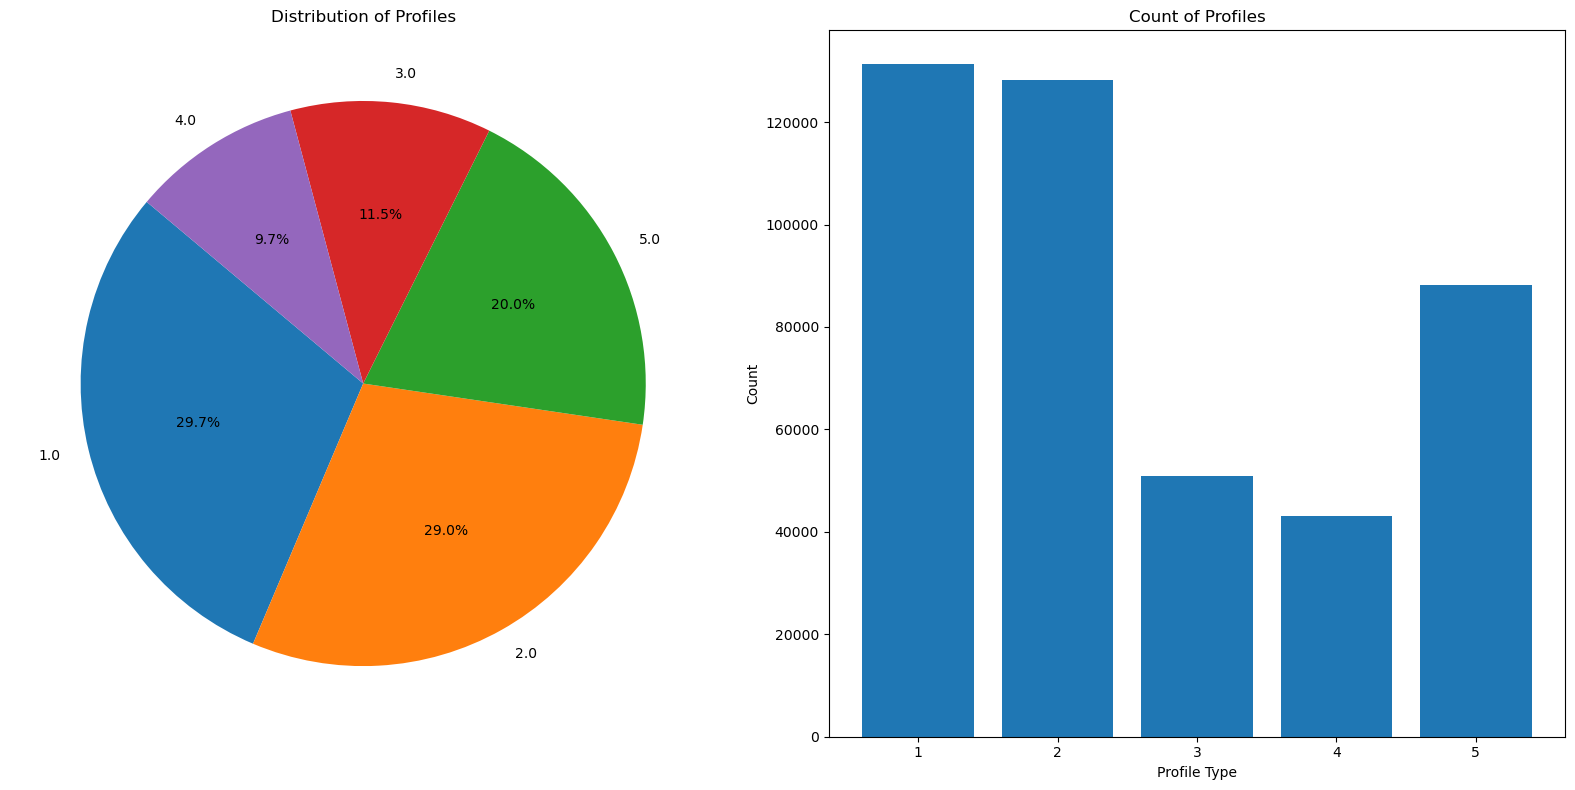

In [ ]:
# Drop rows with NaN values in 'profile' column
races_df_profile = races_df.dropna(subset=['profile'])

# Count the occurrences of each profile type
profile_counts = races_df_profile['profile'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the pie chart
axs[0].pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Profiles')

# Plot the bar chart
axs[1].bar(profile_counts.index, profile_counts.values)
axs[1].set_title('Count of Profiles')
axs[1].set_xlabel('Profile Type')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

... But the description is wrong. There are 5 different profiles.

Let's check the average temperature

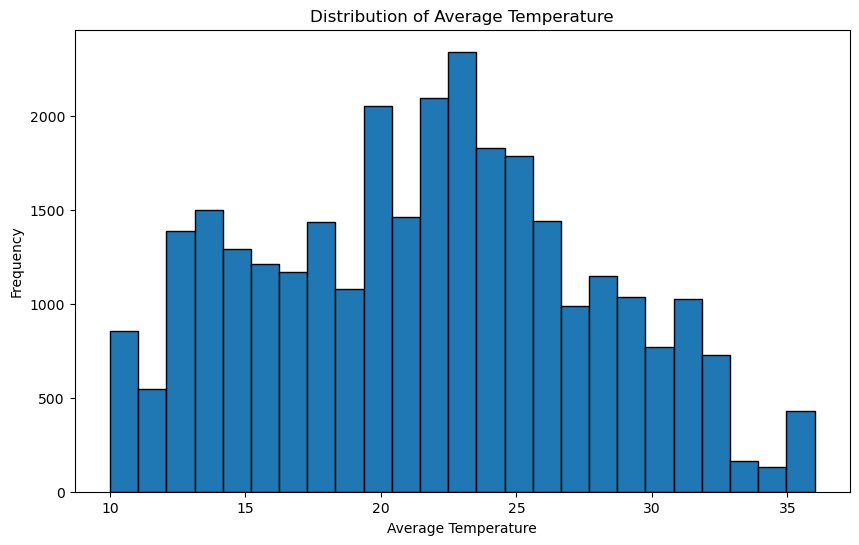

In [ ]:
# Drop rows with NaN values in 'average_temperature' column
dt_cyclism_temp = races_df.dropna(subset=['average_temperature'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(dt_cyclism_temp['average_temperature'], bins=25, edgecolor='black')
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.show()

Are these Kelvin? Probably not. Fahrenheit? No way. It's surely Celsius. <br>
Is there a correlation between these two distributions? Let's make a scatter plot 

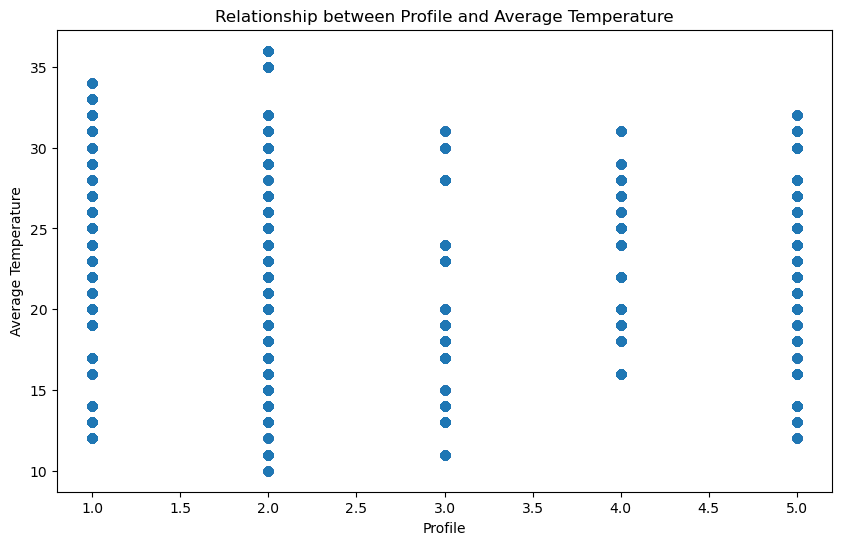

In [ ]:
# Drop rows with NaN values in 'profile' and 'average_temperature' columns
dt_cyclism_profile_temp = races_df.dropna(subset=['profile', 'average_temperature'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dt_cyclism_profile_temp['profile'], dt_cyclism_profile_temp['average_temperature'], alpha=0.5)
plt.title('Relationship between Profile and Average Temperature')
plt.xlabel('Profile')
plt.ylabel('Average Temperature')
plt.show()

Looks like not. Weird, we expected a higher terrain would mean lower average temperatures. <br>
Let's check how the points are distributed.

In [ ]:
dt_points = pd.DataFrame.copy(races_df)
dt_points = dt_points[['name_stage', 'points']]
print(dt_points.shape)

(589818, 2)


Now plot it

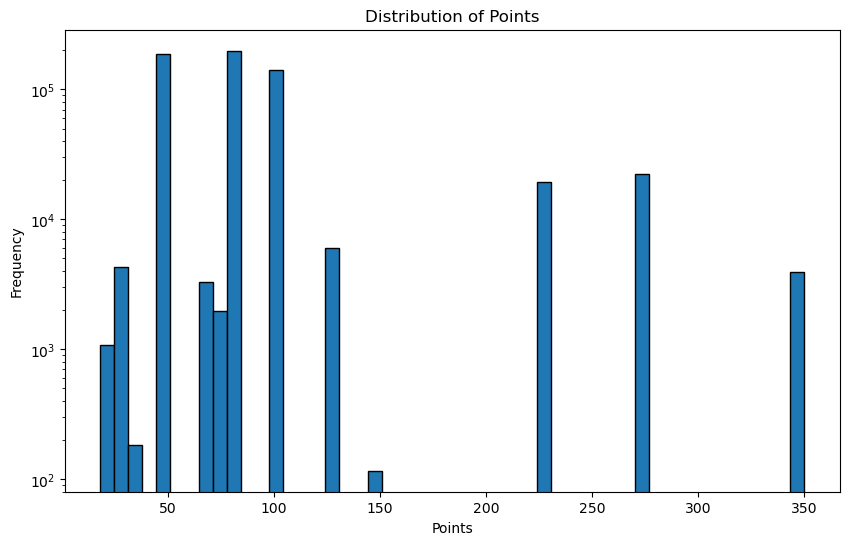

In [ ]:
# Plot the histogram for the distribution of points in log scale
plt.figure(figsize=(10, 6))
plt.hist(dt_points['points'], bins=50, edgecolor='black', log=True)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

We can see that the points aren't smoothly distributed. They are just skewed towards some values.

Let's check the top races

In [ ]:
# Sort the top_races DataFrame by the 'points' column in descending order
dt_points = pd.DataFrame.copy(races_df)
dt_points = dt_points[['name_stage', 'points']]
dt_points = dt_points.drop_duplicates()
dt_points = dt_points.sort_values(by='points', ascending=False)


# Display the top races
print(dt_points.head(10))

                        name_stage  points
12179    world-championship_result   350.0
32005          il-lombardia_result   275.0
1483         milano-sanremo_result   275.0
7724   liege-bastogne-liege_result   275.0
1269   ronde-van-vlaanderen_result   275.0
8318          paris-roubaix_result   275.0
25314         san-sebastian_result   225.0
41565             gp-quebec_result   225.0
31477        strade-bianche_result   225.0
43455           gp-montreal_result   225.0


What about the worst races?

In [ ]:
dt_points = dt_points.sort_values(by='points', ascending=True)


# Display the top races
print(dt_points.head(10))

                 name_stage  points
557418    dauphine_prologue    18.0
283896   paris-nice_stage-5    18.0
41450   gran-camino_stage-4    20.0
11922   gran-camino_stage-3    20.0
2565    gran-camino_stage-2    20.0
54395   gran-camino_stage-1    20.0
433308     dauphine_stage-7    30.0
492989   paris-nice_stage-8    30.0
329515    dauphine_prologue    30.0
27267    paris-nice_stage-4    30.0


Interesting! Seems that `*_result` races are valued more than their prologues or stages. **MISLEADING**: non tutte le gare hanno un `prologue` o un `result`

Let's see how the lengths are distributed

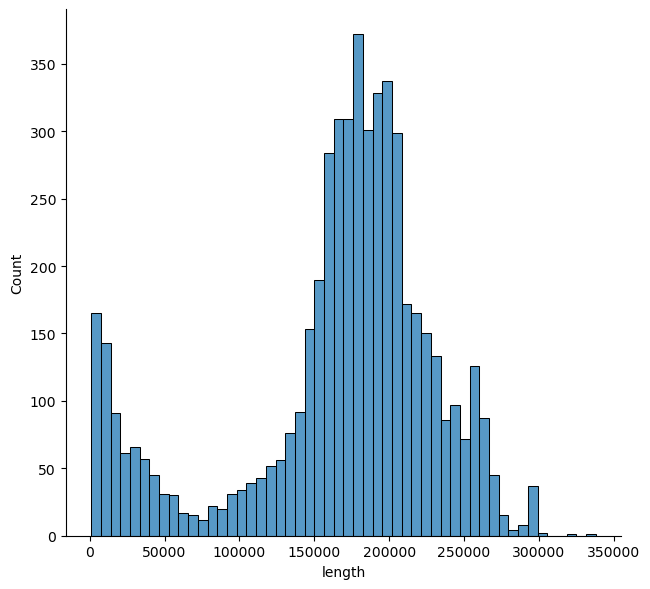

In [ ]:
aggregated_stages = races_df.groupby('_url').agg({'length':'first'}).reset_index()

sns.displot(aggregated_stages,
                x='length',
                kind='hist',
                aspect=1.1,
                height=6
)

Some races are set to be of length 0... we'll have to impute some data.

What about the total distance to climb? Let's plot an histogram

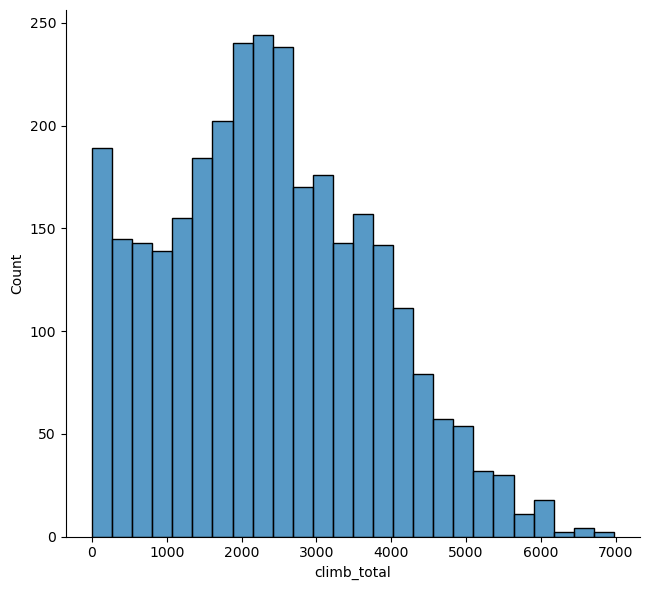

In [ ]:
aggregated_stages = races_df.groupby('_url').agg({'climb_total':'first'}).reset_index()

sns.displot(aggregated_stages,
                x='climb_total',
                kind='hist',
                aspect=1.1,
                height=6
)

Here, a lot of them are 0. As for the `delta` attribute, we may not know if these are missing values or just really flat races. Maybe, we can do some checks at a later moment.

Let's check some correlations

In [ ]:
normalized_dataset, normalization_scalers_dataset = center_and_scale(races_df)
corr = correlations(normalized_dataset)
corr

,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,position,cyclist_age,delta,correlation_type
points,1.000000,0.486830,0.283637,0.044905,-0.097831,0.387374,0.153829,0.011516,-0.005482,0.068584,kendall
uci_points,0.486830,1.000000,0.098587,0.046858,-0.000465,0.007000,0.066502,-0.023719,0.007526,0.070373,kendall
length,0.283637,0.098587,1.000000,0.285127,0.017447,0.064083,-0.095313,-0.015393,-0.002368,0.029241,kendall
climb_total,0.044905,0.046858,0.285127,1.000000,0.578130,0.009045,-0.079710,-0.023856,0.005525,0.356188,kendall
profile,-0.097831,-0.000465,0.017447,0.578130,1.000000,-0.092416,-0.020977,-0.018415,0.005643,0.420176,kendall
startlist_quality,0.387374,0.007000,0.064083,0.009045,-0.092416,1.000000,0.218390,0.097519,0.033569,0.032268,kendall
average_temperature,0.153829,0.066502,-0.095313,-0.079710,-0.020977,0.218390,1.000000,0.015593,0.033887,0.023630,kendall
position,0.011516,-0.023719,-0.015393,-0.023856,-0.018415,0.097519,0.015593,1.000000,0.006382,0.296572,kendall
cyclist_age,-0.005482,0.007526,-0.002368,0.005525,0.005643,0.033569,0.033887,0.006382,1.000000,-0.002693,kendall
delta,0.068584,0.070373,0.029241,0.356188,0.420176,0.032268,0.023630,0.296572,-0.002693,1.000000,kendall


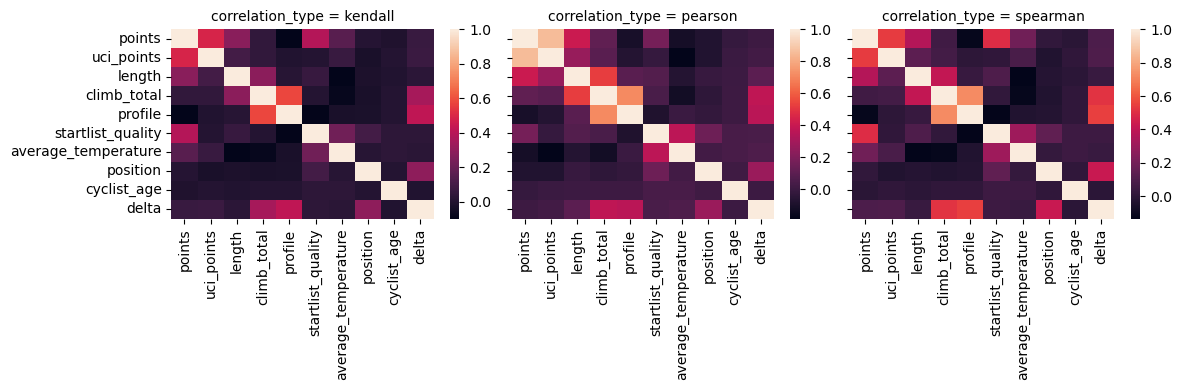

In [ ]:
g = sns.FacetGrid(corr, col="correlation_type", col_wrap=3, height=4)
g.map_dataframe(lambda data, color: sns.heatmap(data[data.columns[:-1]]))

Now let's talk a bit about cyclists.

In [ ]:
cyclist_df.describe().drop('count')

,birth_year,weight,height
mean,1974.071884,68.658739,179.815145
std,15.535834,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


The mean weight is higher than the average World weight (62.0 kg). It is closer to Europe and Latin America averages (70.8 kg and 67.9 kg). (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3408371/). Let's see how the nationalities are distributed...

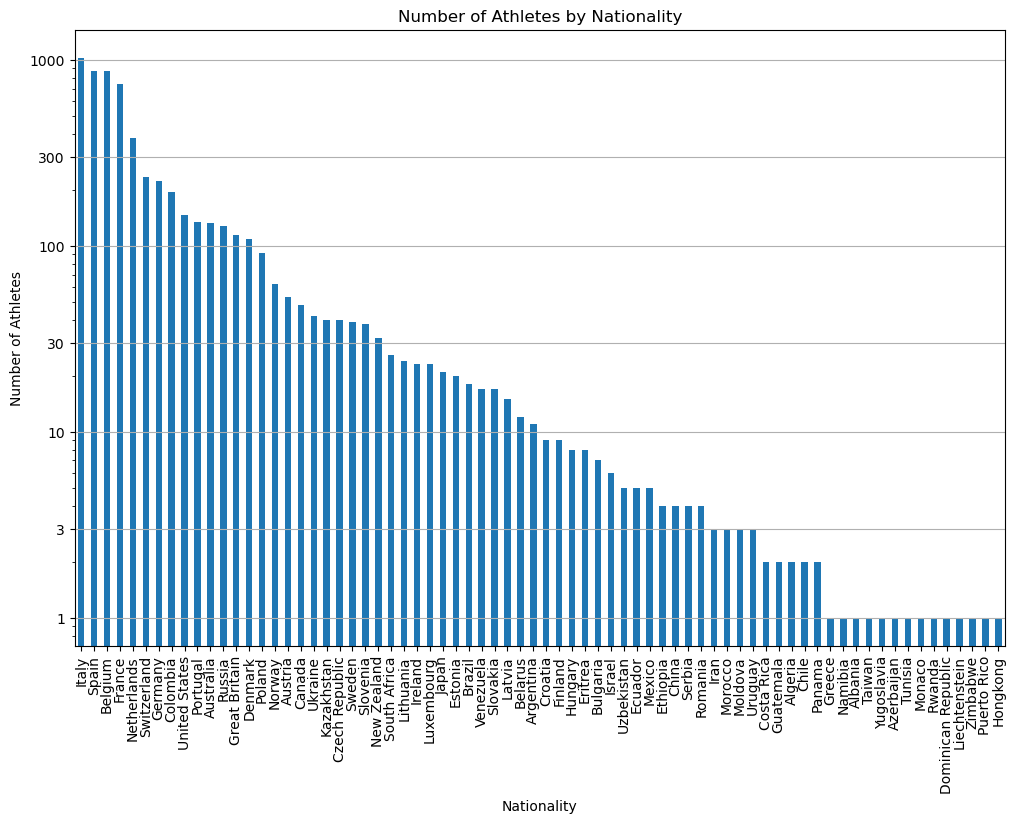

In [ ]:
# Count the number of occurrences of each nationality
nationality_counts = cyclist_df['nationality'].value_counts()

# Sort the nationalities by the number of occurrences
sorted_nationality_counts = nationality_counts.sort_values(ascending=False)


# Display the sorted nationalities and their counts
# Plot the sorted nationalities and their counts
plt.figure(figsize=(12, 8))
sorted_nationality_counts.plot(kind='bar')
plt.title('Number of Athletes by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Athletes')
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000], ['1', '3', '10', '30', '100', '300', '1000'])
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

Who would have thought! Surely, it must be a popular sport in Europe.

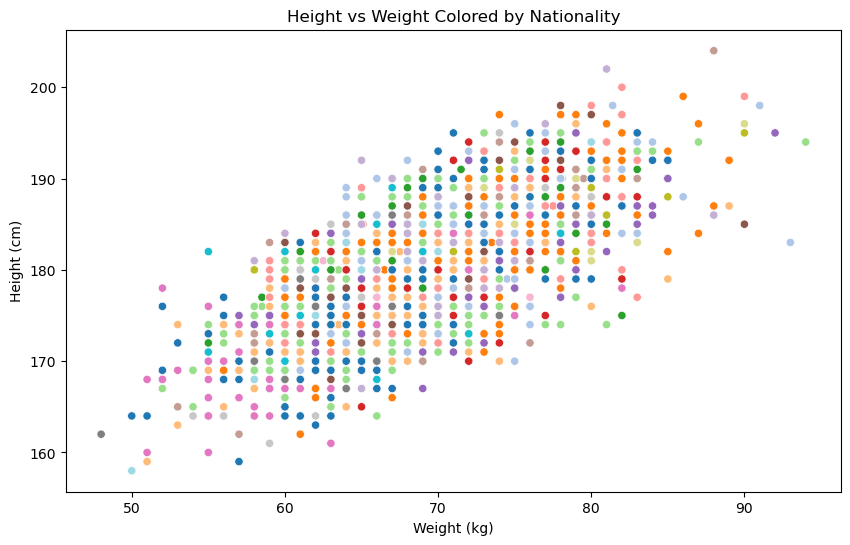

In [ ]:
#  We can filter by nationality
selected_nationalities = ['Italy', 
                          'France', 
                          #'United States', 
                          'Russia'
                          ]
selected_nationalities = None
show_legend = True if selected_nationalities else False

# Drop rows with missing values in weight or height
dt_cyclists_clean = cyclist_df.dropna(subset=['weight', 'height'])

# Filter the data to include only the selected nationalities
if selected_nationalities:
    dt_cyclists_clean = dt_cyclists_clean[dt_cyclists_clean['nationality'].isin(selected_nationalities)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dt_cyclists_clean, x='weight', y='height', hue='nationality', palette='tab20', legend='full')
plt.title('Height vs Weight Colored by Nationality')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.legend(title='Nationality', bbox_to_anchor=(1.05, 1), loc='upper left')
if not show_legend:
    plt.legend([],[], frameon=False)
plt.show()


In the above plot, different colors represent different nationalities. As we can see, it looks like an harlequin. <br>
Let's see if a box plot of the height/weight ratio gives us some insights.

/tmp/ipykernel_7939/652568714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_cyclists_clean.loc[:, 'height_weight_ratio'] = dt_cyclists_clean['height'] / dt_cyclists_clean['weight']


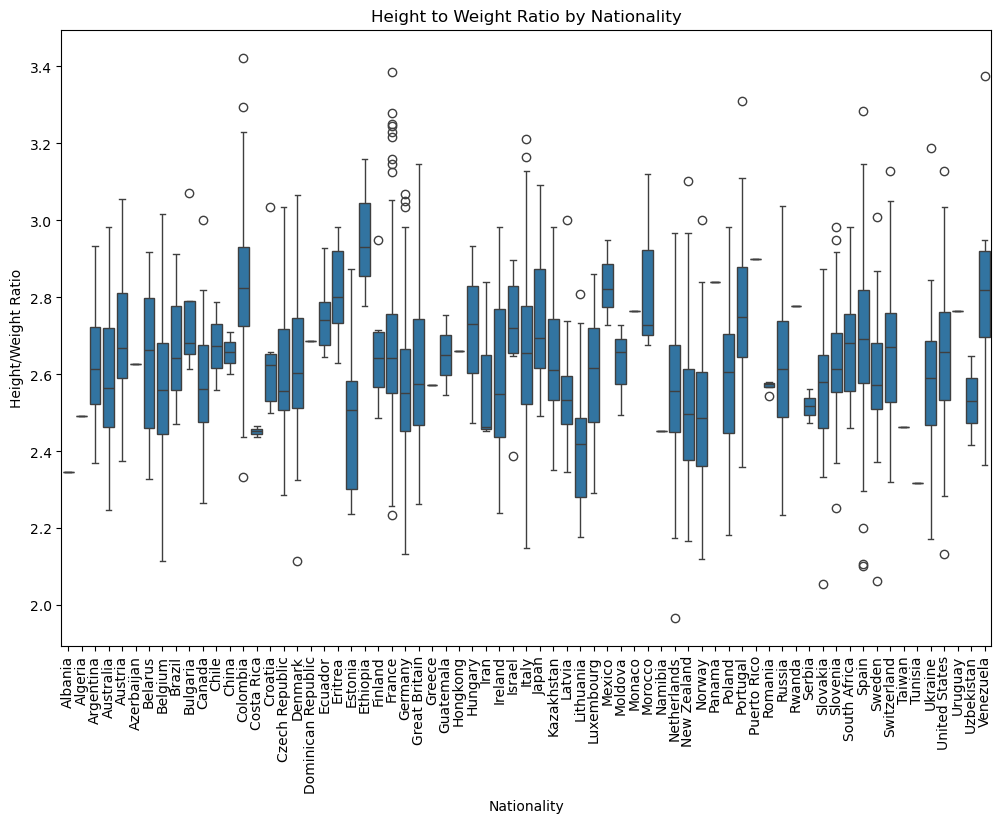

In [ ]:
# Calculate the ratio between height and weight
dt_cyclists_clean.loc[:, 'height_weight_ratio'] = dt_cyclists_clean['height'] / dt_cyclists_clean['weight']
# Calculate the average height_weight_ratio for each nationality and sort
avg_ratio_by_nationality = dt_cyclists_clean.groupby('nationality', observed=True)['height_weight_ratio'].mean().sort_values(ascending=False)

# Sort the dataframe by avg_ratio_by_nationality index
sorted_nationalities = avg_ratio_by_nationality.index
dt_cyclists_clean.loc[:,'nationality'] = pd.Categorical(dt_cyclists_clean['nationality'], categories=sorted_nationalities, ordered=True)

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=dt_cyclists_clean.sort_values('nationality'), x='nationality', y='height_weight_ratio')
plt.title('Height to Weight Ratio by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Height/Weight Ratio')
plt.xticks(rotation=90)
plt.show()

We can see most nationalities having about the same distributions, while a few nationalities are a bit skewed towards higher/smaller ratios. Also, as we noted before, a lot of nationalities have just one cyclist representing them.

One last interesting thing we might see is when were people born.

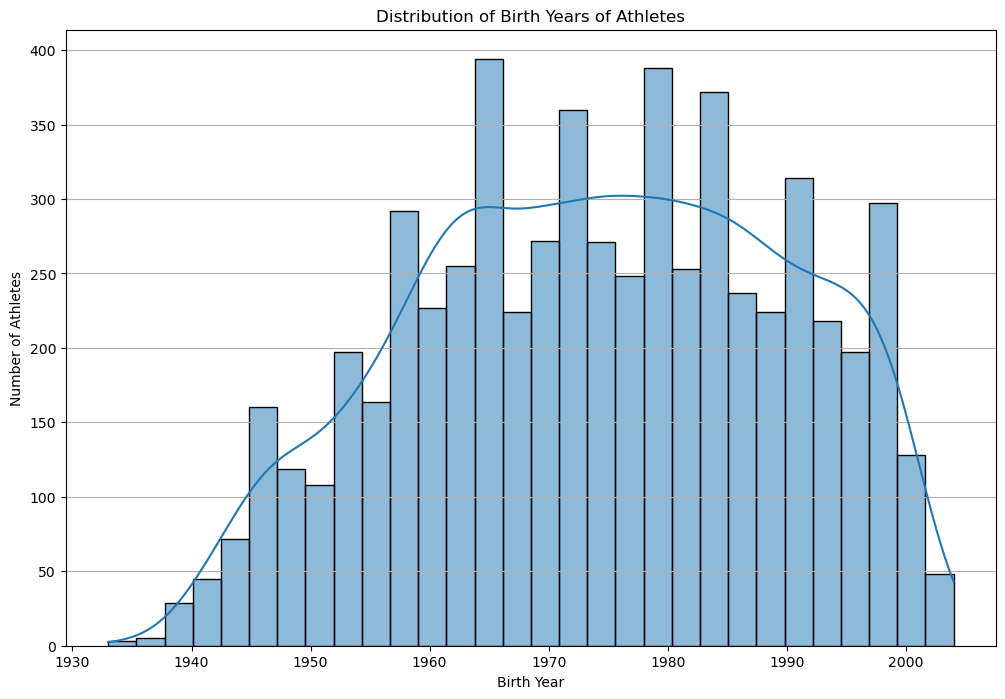

In [ ]:
# Plot the distribution of birth years
plt.figure(figsize=(12, 8))
sns.histplot(cyclist_df['birth_year'].dropna(), bins=30, kde=True)
plt.title('Distribution of Birth Years of Athletes')
plt.xlabel('Birth Year')
plt.ylabel('Number of Athletes')
plt.grid(axis='y')
plt.show()

This does not seem all that interesting. The shape of the histogram is what it is probably because of several reasons: The "old" athletes indicated were the ones still alive in the year span the dataset was considering (or maybe older data is quite more difficult and expensive to gather). A similar reasoning can be done for the "young" athletes. <br>
This does not mean that cyclism was not popular for people born before 1940...